In [1]:
from bayes_tec.datapack import DataPack
from bayes_tec.logging import logging
from bayes_tec.utils.data_utils import make_coord_array
import numpy as np
import os
import astropy.time as at

def make_example_datapack(Nd,Nf,Nt,pols=None, time_corr=50.,dir_corr=0.5*np.pi/180.,tec_scale=0.02,tec_noise=1e-3,name='test.hdf5',clobber=False):
    logging.info("=== Creating example datapack ===")
    name = os.path.abspath(name)
    if os.path.isfile(name) and clobber:
        os.unlink(name)

    datapack = DataPack(name,readonly=False)
    with datapack:
        datapack.add_antennas()
        datapack.add_sources(np.random.normal(np.pi/4.,np.pi/180.*2.5,size=[Nd,2]))
        _, directions = datapack.sources
        _, antennas = datapack.antennas
        ref_dist = np.linalg.norm(antennas - antennas[0:1,:],axis=1)[None,None,:,None]#1,1,Na,1

        times = at.Time(np.linspace(0,Nt*8,Nt)[:,None],format='gps').mjd*86400.#mjs
        freqs = np.linspace(120,160,Nf)*1e6
        if pols is not None:
            use_pols = True
            assert isinstance(pols,(tuple,list))
        else:
            use_pols = False
            pols = ['XX']
            
        tec_conversion = -8.440e9/freqs #Nf
        
        X = make_coord_array(directions/dir_corr, times/time_corr)# Nd*Nt, 3
        X2 = np.sum((X[:,:,None] - X.T[None,:,:])**2, axis=1)#N,N
        K = tec_scale**2 * np.exp(-0.5*X2)
        L = np.linalg.cholesky(K + 1e-6*np.eye(K.shape[0]))#N,N
        Z = np.random.normal(size=(K.shape[0],len(pols)))#N,npols
        tec = np.einsum("ab,bc->ac",L,Z)#N,npols
        tec = tec.reshape((Nd,Nt,len(pols))).transpose((2,0,1))#Npols,Nd,Nt
        tec = tec[:,:,None,:]*(0.2+ref_dist/np.max(ref_dist))#Npols,Nd,Na,Nt
#         print(tec)
        tec += tec_noise*np.random.normal(size=tec.shape)
        phase = tec[:,:,:,None,:]*tec_conversion[None,None,None,:,None]##Npols,Nd,Na,Nf,Nt
#         print(phase)
        phase = np.angle(np.exp(1j*phase))
        
        if not use_pols:
            phase = phase[0,...]
            pols = None
        datapack.add_freq_dep_tab('phase',times=times,freqs=freqs,pols=pols,vals=phase)
        datapack.phase = phase
        return datapack

2018-08-02 20:18:54,418 === Creating example datapack ===
2018-08-02 20:18:54,419 Creating /home/josh/git/bayes_tec/notebooks/devel/new_test.hdf5.
2018-08-02 20:18:54,421 Creating a new solution-set: sol000.
2018-08-02 20:18:54,422 --Creating new antenna table.
2018-08-02 20:18:54,424 --Creating new source table.
2018-08-02 20:18:54,426 Closing table.
2018-08-02 20:18:54,427 Appending to /home/josh/git/bayes_tec/notebooks/devel/new_test.hdf5.


/home/josh/anaconda3/envs/kerastf/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):
/home/josh/anaconda3/envs/kerastf/lib/python3.6/site-packages/tables/atom.py:393: FlavorWarning: support for unicode type is very limited, and only works for strings that can be cast as ascii
  "and only works for strings that can be cast as ascii", FlavorWarning)


2018-08-02 20:19:03,609 Creating a new solution-table: phase000.
2018-08-02 20:19:03,739 Closing table.
2018-08-02 20:19:03,829 Appending to /home/josh/git/bayes_tec/notebooks/devel/new_test.hdf5.


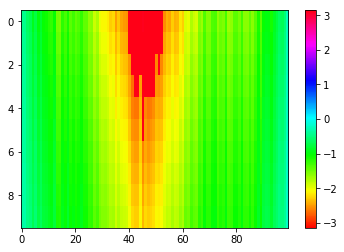

2018-08-02 20:19:04,033 Closing table.


In [2]:
import pylab as plt
from bayes_tec.plotting.plot_datapack import DatapackPlotter,animate_datapack

datapack = make_example_datapack(90,10,100,pols=['XX'],name='new_test.hdf5',time_corr=80,tec_scale=0.02,clobber=True)
# animate_datapack(datapack,'figs',num_processes=8)
with datapack:
    phase,axes = datapack.phase
    plt.imshow(phase[0,0,51,:,:],aspect='auto',cmap='hsv',vmin=-np.pi,vmax=np.pi)
    plt.colorbar()
    plt.show()